In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns
from pathlib import Path

# create column with values 'other', 'inf', 'eps', 'zero'
def classify_isinf(row):
    if row['isinf']:
        return 'inf'
    elif row['cone_eps']:
        return 'eps'
    elif row['value'] == 0:
        return 'zero'
    else:
        return 'other'

In [2]:
# Path rglob all JSON files in benchmarks/ directory load into a single DataFrame
dfs = []
for file in Path(".").rglob("cone_bars_benchmark_results*.json"):
    print(f"Cargando {file}")
    with open(file, "r") as f:
        data = json.load(f)
    dfs.append(pd.DataFrame(data))

df = pd.concat(dfs, ignore_index=True)

Cargando cone_bars_benchmark_results_001.json
Cargando cone_bars_benchmark_results_002.json
Cargando cone_bars_benchmark_results_003.json
Cargando cone_bars_benchmark_results_004.json


In [3]:
df["logid"] = df['n_points'].astype(str) + "_" +  df['generator'] + "_" + df['mapping']+ "_m" + df['m'].astype(str)+"_seed" + df['seed'].astype(str) + "_L" + df['L_scale'].astype(str)
df['class'] = df.apply(classify_isinf, axis=1)
df[['class', 'n_matches']].value_counts().sort_index().unstack()

n_matches,0,1,2,3,20,30,39,40,50,75,99,100
class,,,,,,,,,,,,
eps,23590.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inf,1080.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
other,NaN,67515.0,143.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zero,NaN,NaN,NaN,NaN,2835.0,2835.0,2835.0,2835.0,6885.0,6885.0,6885.0,6885.0


In [4]:
df['logid'].nunique()

1080

In [5]:
(df.value_counts(['logid','bar_id']) == 2).all()

np.True_

In [6]:
df.groupby('logid')['class'].value_counts().unstack()

class,eps,inf,other,zero
logid,,,,
20_annulus_inclusion_m10_seed100_L0.1,10,1,34,21
20_annulus_inclusion_m10_seed101_L0.1,10,1,32,21
20_annulus_inclusion_m10_seed102_L0.1,10,1,32,21
20_annulus_inclusion_m10_seed109_L0.5,10,1,34,21
20_annulus_inclusion_m10_seed110_L0.5,10,1,36,21
...,...,...,...,...
50_uniform_3d_projection_m50_seed308_L0.5,50,1,144,51
50_uniform_3d_projection_m50_seed309_L0.5,50,1,162,51
50_uniform_3d_projection_m50_seed310_L1.0,50,1,146,51


In [7]:
df.value_counts(['m','n_points'])

m   n_points
50  50          30002
49  50          25648
25  50          22210
1   50          16532
20  20          11670
19  20          10028
10  20           8642
1   20           6478
Name: count, dtype: int64

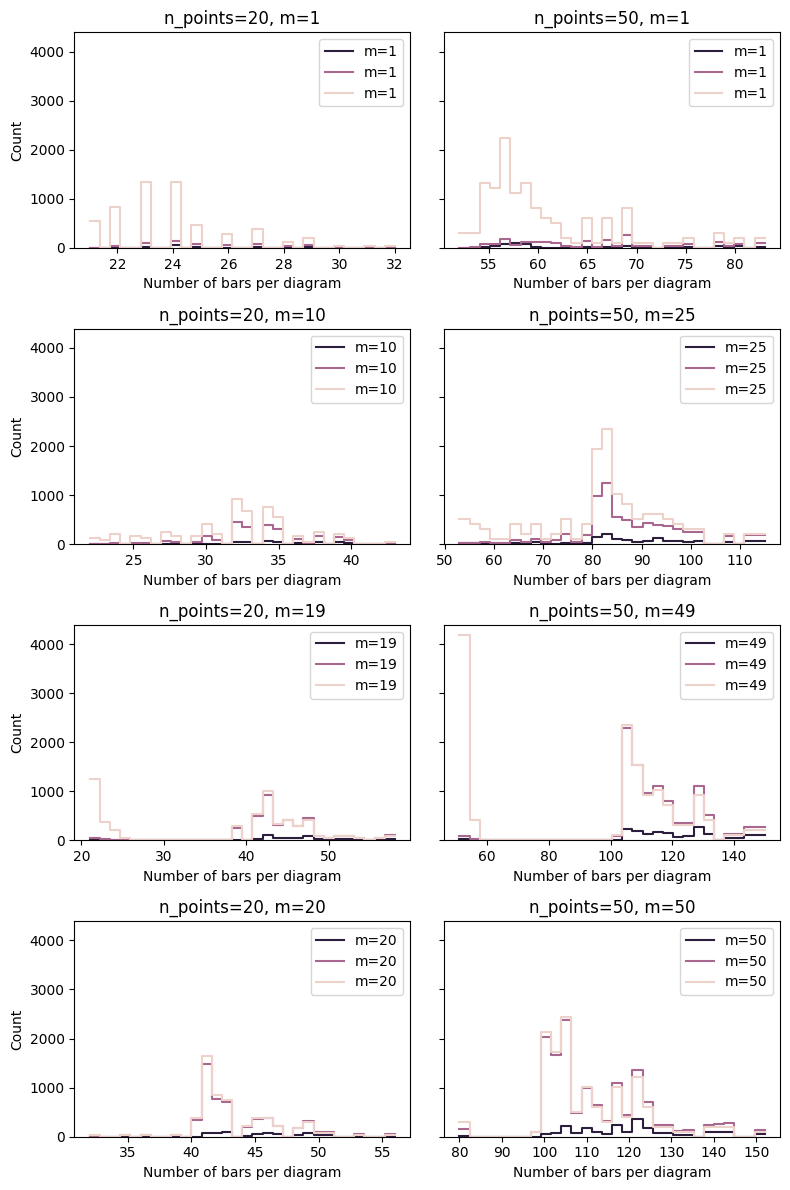

In [8]:
# seaborn histogram of number of bars per diagram hue=dim, step style no fill


# mxn subplot grid, separate n_points and m value
n_points_vals = sorted(df['n_points'].unique())
m_vals = 4
fig, axes = plt.subplots( m_vals, len(n_points_vals),figsize=(8, 12), sharey=True)
for i, n_points in enumerate(n_points_vals):
    m_vals = sorted(df[df['n_points'] == n_points]['m'].unique())
    for j, m in enumerate(m_vals):
        ax = axes[j, i]
        sns.histplot(data=df[(df['n_points'] == n_points) & (df['m'] == m)], x='n_bars', hue='dim', bins=30, element='step', fill=False, ax=ax, label=f'm={m}')
        ax.set_xlabel('Number of bars per diagram')
        ax.set_title(f'n_points={n_points}, m={m}')
        ax.legend()
plt.tight_layout()


In [9]:
# create new column with indices length of matches
df["idx_matches"] = df["matches"].map(lambda x: np.arange(len(x)))
# expand matches column into multiple rows
df = df.explode(["idx_matches", "matches"])
# expand matches dictionary into separate columns
matches_df = pd.json_normalize(df["matches"])
matches_df.columns = [f"match_{col}" for col in matches_df.columns]
df = pd.concat([df.reset_index(drop=True), matches_df.reset_index(drop=True)], axis=1)
df['dup_value_bod_logid'] = df.duplicated(subset=['value', 'bod', 'logid'], keep=False)

# remove both bar_id if one is inf, eps, zero classes 
to_remove = df[df['class'].isin(['inf','eps','zero'])][['logid','bar_id']].set_index(['logid','bar_id'])
# dfx = df[df['class'] == 'other'].copy()
df.set_index(['logid','bar_id'], inplace=True)
dfx = df[~df.index.isin(to_remove.index)].copy().reset_index()

In [10]:
for k,g in dfx.groupby(["logid","bar_id"]):    

    if len(g) != 2 or g['bod'].nunique() != 2 :
        dfx.loc[g.index, 'match_type'] = 'unknown'
        continue
    
    rows = {}
    r = g.iloc[0]
    rows[r['bod']] = r
    r = g.iloc[1]
    rows[r['bod']] = r
    b = rows['birth']
    d = rows['death']
    
    match_type = []

    # coker_a
    # b_c = b_y_i
    # d_c = d_y_i
    if b['dim']==b['match_bar_dim'] and b['match_match_kind']=="birth" and b['match_diagram']=="Y" and \
       d['dim']==d['match_bar_dim'] and d['match_match_kind']=="death" and d['match_diagram']=="Y":
        match_type.append('coker_a')
    
    # coker_b
    # b_c = b_y_i
    # d_c = b_x_j
    if b['dim']==b['match_bar_dim'] and b['match_match_kind']=="birth" and b['match_diagram']=="Y" and \
       d['dim']==d['match_bar_dim'] and d['match_match_kind']=="birth" and d['match_diagram']=="X":
        match_type.append('coker_b')

    if b['dim']>=0 and d['dim']>=0:
        # ker_a
        # b_c = b_x_i (dim-1)
        # d_c = d_x_i (dim-1)
        if b['dim']==b['match_bar_dim']-1 and b['match_match_kind']=="birth" and b['match_diagram']=="X" and \
        d['dim']==d['match_bar_dim']-1 and d['match_match_kind']=="death" and d['match_diagram']=="X":
            match_type.append('ker_a')

        # ker_b
        # b_c = d_y_i (dim-1)
        # d_c = d_x_j (dim-1)
        if b['dim']==b['match_bar_dim']-1 and b['match_match_kind']=="death" and b['match_diagram']=="Y" and \
        d['dim']==d['match_bar_dim']-1 and d['match_match_kind']=="death" and d['match_diagram']=="X":
            match_type.append('ker_b')

    if len(match_type) == 0:
        match_type.append('unmatched')
    dfx.loc[g.index, 'match_type'] = ','.join(match_type)

In [11]:
(dfx['match_bar_dim']>dfx['dim']).value_counts()

False    52603
True         7
Name: count, dtype: int64

In [15]:
dfy = dfx.groupby('logid')['match_type'].value_counts().unstack()
dfy

match_type,coker_a,coker_b,unknown,unmatched
logid,,,,
20_annulus_inclusion_m10_seed100_L0.1,4.0,NaN,NaN,20.0
20_annulus_inclusion_m10_seed101_L0.1,2.0,NaN,NaN,20.0
20_annulus_inclusion_m10_seed102_L0.1,2.0,NaN,NaN,20.0
20_annulus_inclusion_m10_seed109_L0.5,4.0,NaN,NaN,20.0
20_annulus_inclusion_m10_seed110_L0.5,6.0,NaN,NaN,20.0
...,...,...,...,...
50_uniform_3d_projection_m50_seed308_L0.5,8.0,NaN,NaN,136.0
50_uniform_3d_projection_m50_seed309_L0.5,22.0,NaN,NaN,140.0
50_uniform_3d_projection_m50_seed310_L1.0,8.0,NaN,6.0,134.0


In [13]:
dfy[dfy['unmatched']==0]

match_type,coker_a,coker_b,unknown,unmatched
logid,,,,


In [26]:
df.value_counts(['mapping','L_lipschitz']).sort_index().unstack().T

mapping,inclusion,projection
L_lipschitz,,
0.995492,NaN,901.0
0.999402,NaN,911.0
0.999551,NaN,901.0
0.999725,NaN,901.0
0.999756,NaN,901.0
...,...,...
1.000000,NaN,1804.0
1.000000,NaN,5269.0
1.000000,NaN,5251.0
